In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [ ]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [ ]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)
img

torch.Size([3, 1365, 2048])


tensor([[[ 79,  80,  80,  ...,  75,  75,  76],
         [ 79,  80,  80,  ...,  75,  75,  76],
         [ 79,  80,  80,  ...,  75,  75,  76],
         ...,
         [121, 121, 122,  ...,  97,  96,  96],
         [121, 121, 122,  ...,  97,  97,  96],
         [121, 121, 122,  ...,  98,  97,  97]],

        [[ 52,  53,  53,  ...,  55,  55,  54],
         [ 52,  53,  53,  ...,  55,  55,  54],
         [ 52,  53,  53,  ...,  55,  55,  54],
         ...,
         [103, 103, 104,  ...,  82,  81,  81],
         [103, 103, 104,  ...,  82,  82,  81],
         [103, 103, 104,  ...,  83,  82,  82]],

        [[ 35,  36,  36,  ...,  30,  30,  30],
         [ 35,  36,  36,  ...,  30,  30,  30],
         [ 35,  36,  36,  ...,  30,  30,  30],
         ...,
         [ 37,  37,  38,  ...,  43,  42,  42],
         [ 37,  37,  38,  ...,  43,  43,  42],
         [ 37,  37,  38,  ...,  44,  43,  43]]], dtype=torch.uint8)

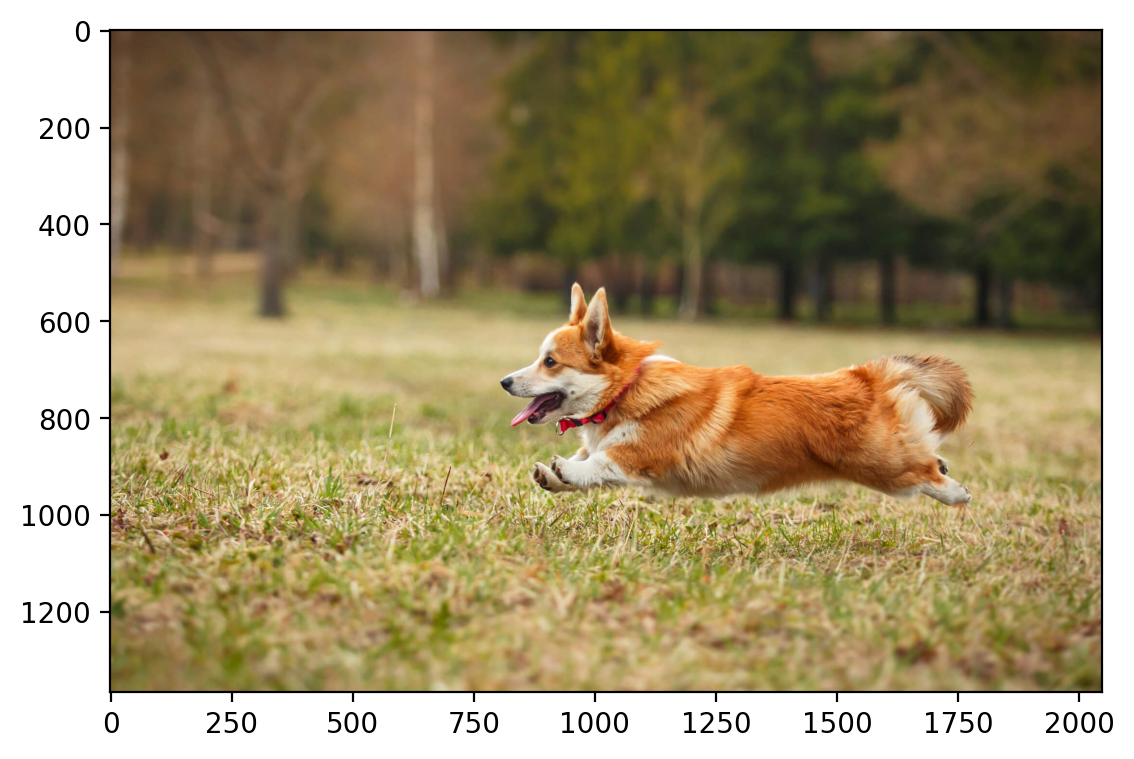

In [ ]:
plt.imshow(img.permute(1, 2, 0))


In [ ]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

tensor([[[0.3098, 0.2039, 0.1373],
         [0.3137, 0.2078, 0.1412],
         [0.3137, 0.2078, 0.1412],
         ...,
         [0.2941, 0.2157, 0.1176],
         [0.2941, 0.2157, 0.1176],
         [0.2980, 0.2118, 0.1176]],

        [[0.3098, 0.2039, 0.1373],
         [0.3137, 0.2078, 0.1412],
         [0.3137, 0.2078, 0.1412],
         ...,
         [0.2941, 0.2157, 0.1176],
         [0.2941, 0.2157, 0.1176],
         [0.2980, 0.2118, 0.1176]],

        [[0.3098, 0.2039, 0.1373],
         [0.3137, 0.2078, 0.1412],
         [0.3137, 0.2078, 0.1412],
         ...,
         [0.2941, 0.2157, 0.1176],
         [0.2941, 0.2157, 0.1176],
         [0.2980, 0.2118, 0.1176]],

        ...,

        [[0.4745, 0.4039, 0.1451],
         [0.4745, 0.4039, 0.1451],
         [0.4784, 0.4078, 0.1490],
         ...,
         [0.3804, 0.3216, 0.1686],
         [0.3765, 0.3176, 0.1647],
         [0.3765, 0.3176, 0.1647]],

        [[0.4745, 0.4039, 0.1451],
         [0.4745, 0.4039, 0.1451],
         [0.

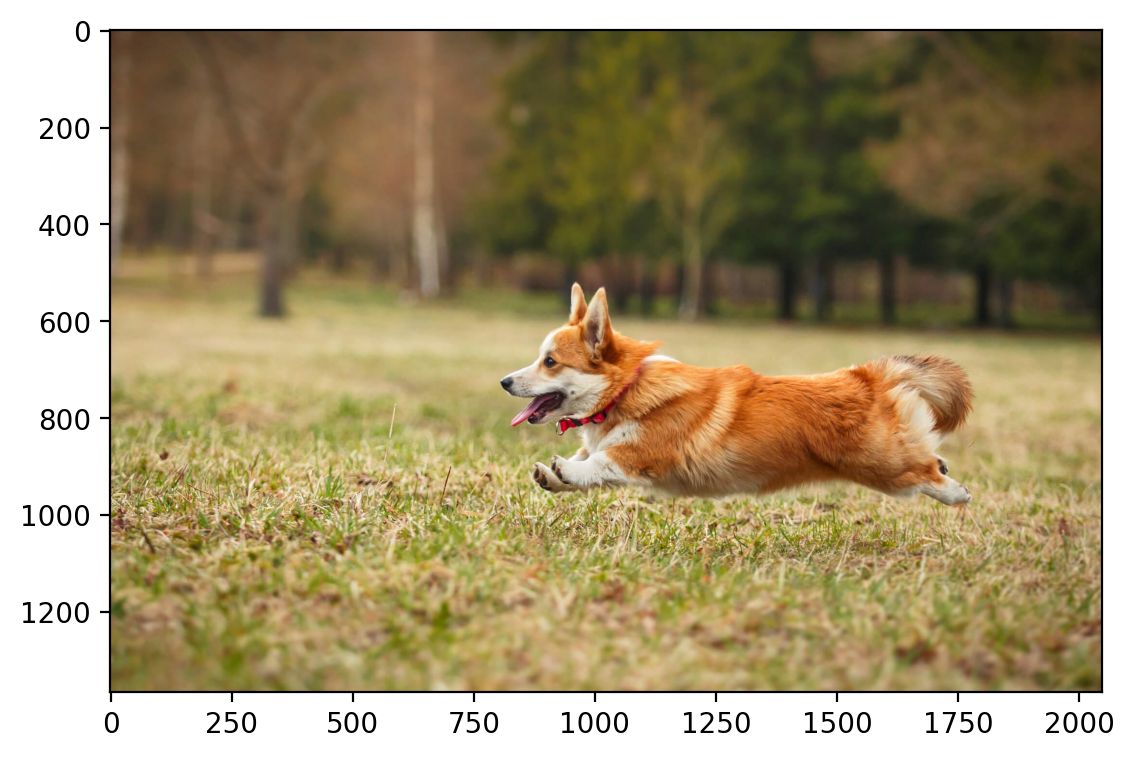

In [ ]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
permuted_img = img_scaled.permute(1, 2, 0)
plt.imshow(permuted_img.detach().cpu())
permuted_img.detach().cpu() 

In [ ]:
crop = transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
crop.shape

torch.Size([3, 300, 300])

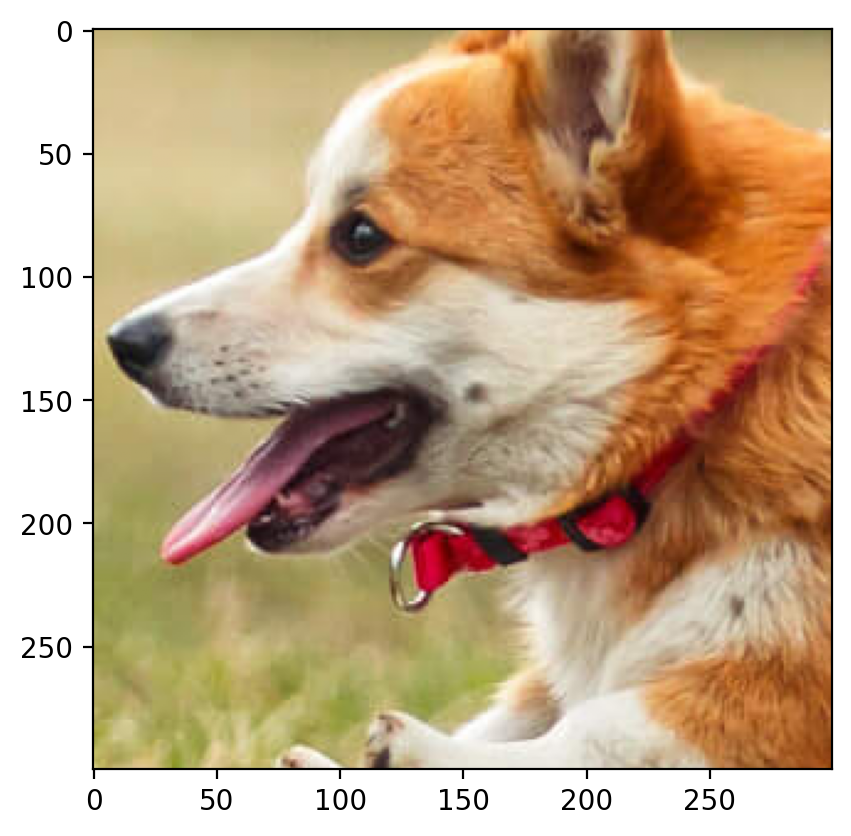

In [ ]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())


In [ ]:
crop = crop.to(device)


In [ ]:
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 300 300


In [ ]:
num_channels, height, width = 2, 3, 4


# Create a 2D grid of (x,y) coordinates
w_coords = torch.arange(width).repeat(height, 1)
print(w_coords)
h_coords = torch.arange(height).repeat(width, 1).t()
w_coords = w_coords.reshape(-1)
h_coords = h_coords.reshape(-1)

# Combine the x and y coordinates into a single tensor
X = torch.stack([h_coords, w_coords], dim=1).float()
h_coords, w_coords, X

tensor([[0, 1, 2, 3],
        [0, 1, 2, 3],
        [0, 1, 2, 3]])


(tensor([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2]),
 tensor([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]),
 tensor([[0., 0.],
         [0., 1.],
         [0., 2.],
         [0., 3.],
         [1., 0.],
         [1., 1.],
         [1., 2.],
         [1., 3.],
         [2., 0.],
         [2., 1.],
         [2., 2.],
         [2., 3.]]))

In [ ]:
X.shape

torch.Size([12, 2])

In [ ]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [ ]:
dog_X, dog_Y = create_coordinate_map(crop)

dog_X.shape, dog_Y.shape, dog_X, dog_Y

(torch.Size([90000, 2]),
 torch.Size([90000, 3]),
 tensor([[  0.,   0.],
         [  0.,   1.],
         [  0.,   2.],
         ...,
         [299., 297.],
         [299., 298.],
         [299., 299.]], device='cuda:0'),
 tensor([[0.7686, 0.6941, 0.4745],
         [0.7686, 0.6941, 0.4745],
         [0.7686, 0.6941, 0.4745],
         ...,
         [0.6275, 0.3294, 0.0863],
         [0.5804, 0.2706, 0.0392],
         [0.5686, 0.2588, 0.0392]]))

In [ ]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()
dog_X_scaled

tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9933],
        [-1.0000, -0.9866],
        ...,
        [ 1.0000,  0.9866],
        [ 1.0000,  0.9933],
        [ 1.0000,  1.0000]], device='cuda:0')

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)


In [ ]:
net = LinearModel(2, 3)
net.to(device)


LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [ ]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [ ]:
train(net, 0.01, dog_X_scaled, dog_Y, 1000)

Epoch 0 loss: 0.514858
Epoch 100 loss: 0.042986
Epoch 200 loss: 0.036826
Epoch 300 loss: 0.036823
Epoch 400 loss: 0.036823
Epoch 500 loss: 0.036823
Epoch 600 loss: 0.036823
Epoch 700 loss: 0.036823
Epoch 800 loss: 0.036823
Epoch 900 loss: 0.036823


0.03682254999876022

In [ ]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

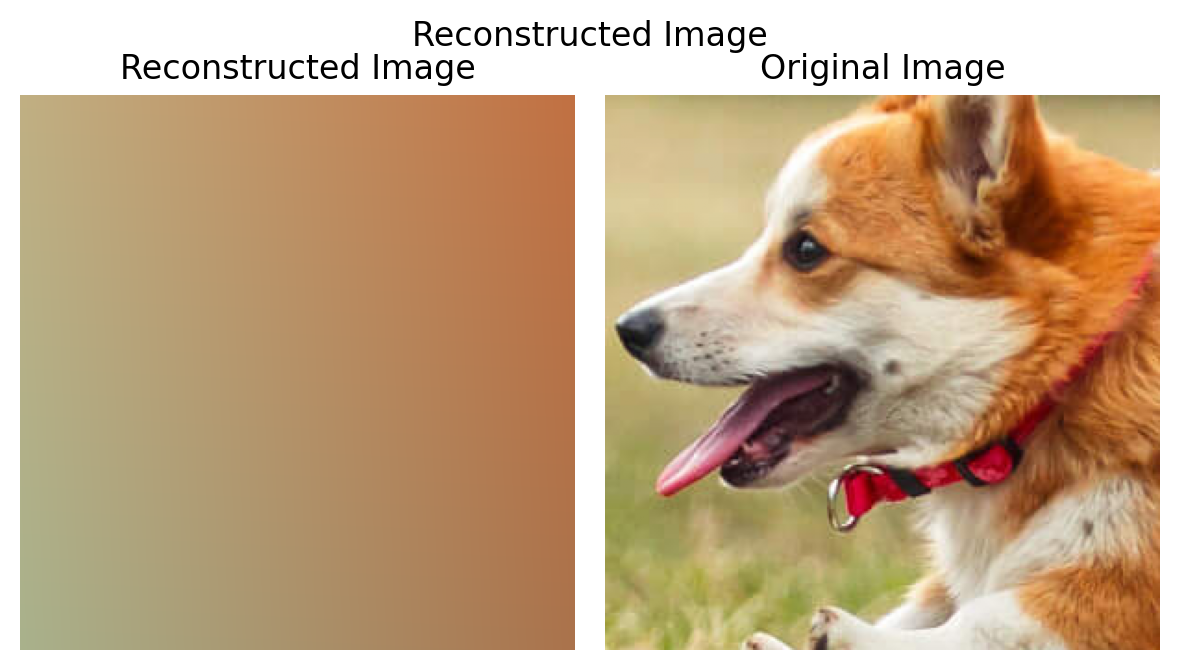

In [ ]:
plot_reconstructed_and_original_image(crop, net, dog_X_scaled, title="Reconstructed Image")

In [ ]:
# Use polynomial features of degree "d"

def poly_features(X, degree):
    """
    X: torch.Tensor of shape (num_samples, 2)
    degree: int

    return: torch.Tensor of shape (num_samples, degree * (degree + 1) / 2)
    """
    X1 = X[:, 0]
    X2 = X[:, 1]
    X1 = X1.unsqueeze(1)
    X2 = X2.unsqueeze(1)
    X = torch.cat([X1, X2], dim=1)
    poly = preprocessing.PolynomialFeatures(degree=degree)
    X = poly.fit_transform(X.cpu())
    return torch.tensor(X, dtype=torch.float32).to(device)

In [ ]:
dog_X_scaled_poly = poly_features(dog_X_scaled, 50)

In [ ]:
dog_X_scaled_poly.dtype, dog_X_scaled_poly

(torch.float32,
 tensor([[ 1.0000, -1.0000, -1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000, -1.0000, -0.9933,  ...,  0.7246,  0.7197,  0.7149],
         [ 1.0000, -1.0000, -0.9866,  ...,  0.5239,  0.5169,  0.5100],
         ...,
         [ 1.0000,  1.0000,  0.9866,  ...,  0.5239,  0.5169,  0.5100],
         [ 1.0000,  1.0000,  0.9933,  ...,  0.7246,  0.7197,  0.7149],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],
        device='cuda:0'))

In [ ]:
net = LinearModel(dog_X_scaled_poly.shape[1], 3)
net.to(device)

train(net, 0.005, dog_X_scaled_poly, dog_Y, 1500)

Epoch 0 loss: 0.346682
Epoch 100 loss: 0.028329
Epoch 200 loss: 0.025188
Epoch 300 loss: 0.024248
Epoch 400 loss: 0.023581
Epoch 500 loss: 0.023050
Epoch 600 loss: 0.022615
Epoch 700 loss: 0.022240
Epoch 800 loss: 0.021914
Epoch 900 loss: 0.021626
Epoch 1000 loss: 0.021373
Epoch 1100 loss: 0.021172
Epoch 1200 loss: 0.020945
Epoch 1300 loss: 0.020792
Epoch 1400 loss: 0.020659


0.02044403739273548

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


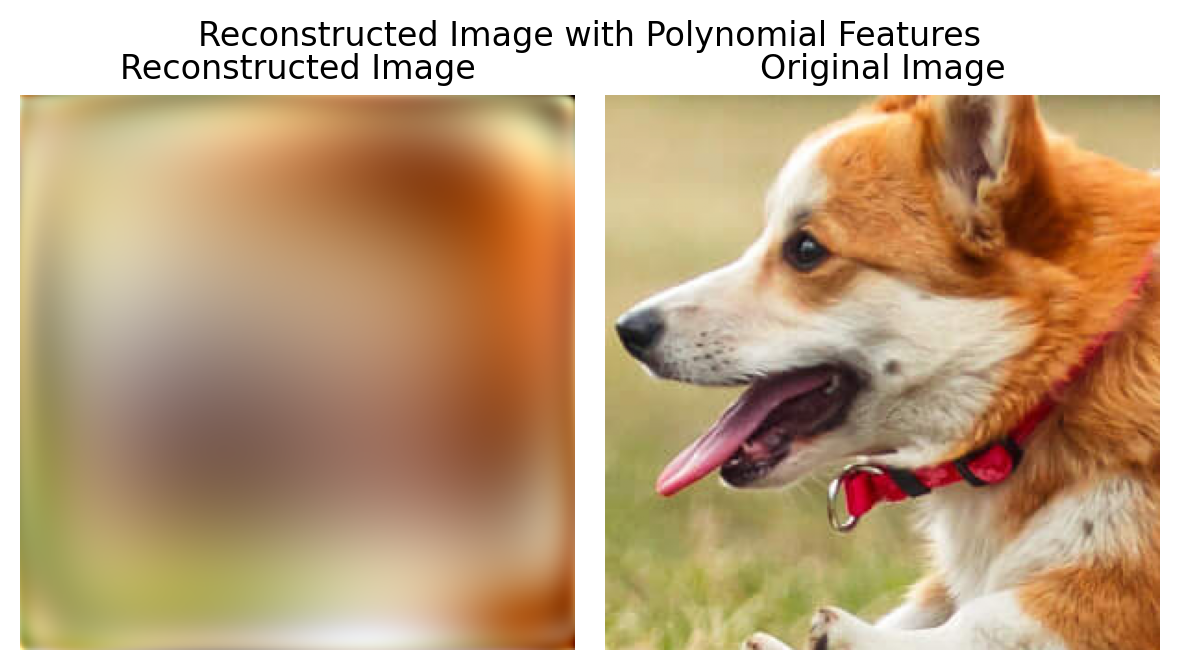

In [ ]:
plot_reconstructed_and_original_image(crop, net, dog_X_scaled_poly, title="Reconstructed Image with Polynomial Features")

In [ ]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)


In [ ]:
X_rff = create_rff_features(dog_X_scaled, 37500, 0.008)

KeyboardInterrupt: 

In [ ]:
X_rff.shape

torch.Size([90000, 37500])

In [ ]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff, dog_Y, 2500)

Epoch 0 loss: 0.375324
Epoch 100 loss: 0.047630
Epoch 200 loss: 0.009158
Epoch 300 loss: 0.003941
Epoch 400 loss: 0.002057
Epoch 500 loss: 0.001118
Epoch 600 loss: 0.000640
Epoch 700 loss: 0.000404
Epoch 800 loss: 0.000292
Epoch 900 loss: 0.000241
Epoch 1000 loss: 0.000218
Epoch 1100 loss: 0.000208
Epoch 1200 loss: 0.000204
Epoch 1300 loss: 0.000201
Epoch 1400 loss: 0.000200
Epoch 1500 loss: 0.000199
Epoch 1600 loss: 0.000198
Epoch 1700 loss: 0.000197
Epoch 1800 loss: 0.000196
Epoch 1900 loss: 0.000195
Epoch 2000 loss: 0.000195
Epoch 2100 loss: 0.000194
Epoch 2200 loss: 0.000194
Epoch 2300 loss: 0.000193
Epoch 2400 loss: 0.000193


0.00019248582248110324

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


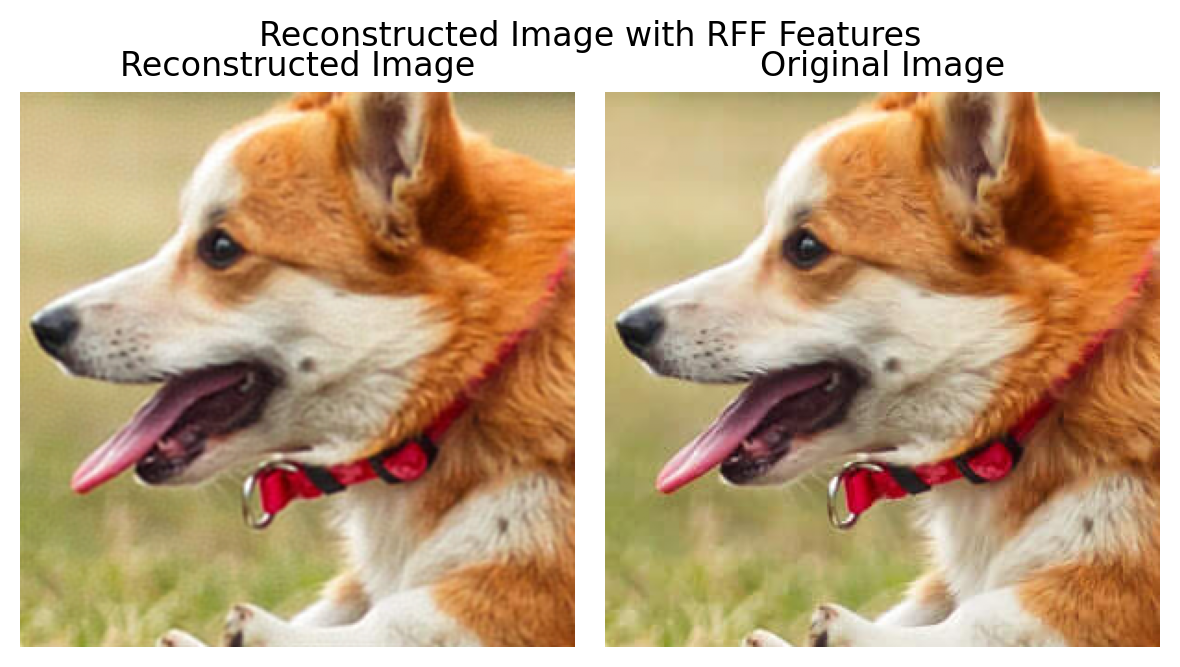

In [ ]:
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")

In [ ]:
w = 100
scale=2
torch.arange(0, w, 1/scale)

tensor([ 0.0000,  0.5000,  1.0000,  1.5000,  2.0000,  2.5000,  3.0000,  3.5000,
         4.0000,  4.5000,  5.0000,  5.5000,  6.0000,  6.5000,  7.0000,  7.5000,
         8.0000,  8.5000,  9.0000,  9.5000, 10.0000, 10.5000, 11.0000, 11.5000,
        12.0000, 12.5000, 13.0000, 13.5000, 14.0000, 14.5000, 15.0000, 15.5000,
        16.0000, 16.5000, 17.0000, 17.5000, 18.0000, 18.5000, 19.0000, 19.5000,
        20.0000, 20.5000, 21.0000, 21.5000, 22.0000, 22.5000, 23.0000, 23.5000,
        24.0000, 24.5000, 25.0000, 25.5000, 26.0000, 26.5000, 27.0000, 27.5000,
        28.0000, 28.5000, 29.0000, 29.5000, 30.0000, 30.5000, 31.0000, 31.5000,
        32.0000, 32.5000, 33.0000, 33.5000, 34.0000, 34.5000, 35.0000, 35.5000,
        36.0000, 36.5000, 37.0000, 37.5000, 38.0000, 38.5000, 39.0000, 39.5000,
        40.0000, 40.5000, 41.0000, 41.5000, 42.0000, 42.5000, 43.0000, 43.5000,
        44.0000, 44.5000, 45.0000, 45.5000, 46.0000, 46.5000, 47.0000, 47.5000,
        48.0000, 48.5000, 49.0000, 49.50

In [ ]:
def create_coordinate_map(img, scale=1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(0, width,  1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [ ]:
create_coordinate_map(crop, scale=2)[0].shape


torch.Size([360000, 2])

In [ ]:
create_coordinate_map(crop, scale=1)[0].shape

torch.Size([90000, 2])